In [2]:
import numpy as np 
import pandas as pd
import os
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report,make_scorer, f1_score, accuracy_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import model_selection
from joblib import dump, load
import mlflow.sklearn
import mlflow
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient

import sys
sys.path.append('../')
from result_display import show_result,export_anomaly
from reject_anomalies import pred_baseon_threshold,make_use_reject_anomalies
from Feature_engineer import remove_unwanted_col,feature_engineer_steps

In [3]:
transactions_df = pd.read_csv("data/transactions_df.csv")
terminal_profiles_df = pd.read_csv("data/terminal_profiles_table.csv")
customer_profiles_df = pd.read_csv("data/customer_profiles_table.csv")
join_terminal = pd.merge(transactions_df, terminal_profiles_df, on='terminal_id', how='inner') #join dataset base on key value
join_customer = pd.merge(join_terminal, customer_profiles_df, on='customer_id', how='inner')


In [17]:
# Feature engineer step and one-hot enconding for categorical feature. 
# Stored in Feature_engineer.py
train_X,train_y = feature_engineer_steps(join_customer)
#  Feature selection as part of the default pipeline
train_X = remove_unwanted_col(train_X)
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y,test_size=0.20, random_state=42)

In [18]:
best_model = load('saved_model/best_model.joblib')

In [19]:
y_pred = best_model.predict(X_test)
y_pred[y_pred == -1] = 0
anomalies = X_test[y_pred == 0]
anomalies_index = anomalies.index

/Users/sek/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [20]:
# train_scores = best_model.decision_function(X_train)
# train_threshold = np.percentile(train_scores, 15) #default set 15% of data are anomalies
# y_pred = pred_baseon_threshold(best_model, X_test, train_threshold) #using threshold to determine anomalies

distances = np.min(best_model.transform(X_train), axis=1)
threshold = np.percentile(distances, 85)
test_distances = np.min(best_model.transform(X_test), axis=1)
y_pred = (test_distances > threshold).astype(int)

/Users/sek/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/sek/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


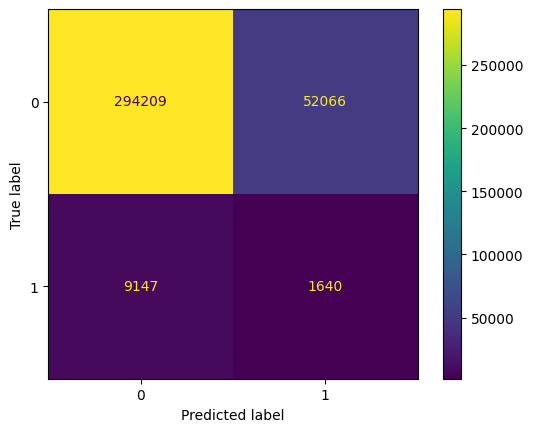

In [25]:
precision, recall, f1_socre = show_result(y_test,y_pred)
# metrics = {"precision": precision, "recall": recall, "f1_socre": f1_socre,"train_threshold":train_threshold}
params = best_model.get_params()

In [26]:
params

{'algorithm': 'lloyd',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 2,
 'n_init': 10,
 'random_state': 0,
 'tol': 0.0001,
 'verbose': 0}